In [1]:
import torch

In [2]:
torch.__version__

'1.7.1'

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [7]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [9]:
import pickle
import numpy as np
with open('cifar-10-batches-py/data_batch_1', 'rb') as fo:
    dict_ = pickle.load(fo, encoding='bytes')

In [11]:
import glob
Train_ = glob.glob('cifar-10-batches-py' + '/data_batch_*')

In [12]:
RGB_X = np.array([])
RGB_Y = np.array([])

In [13]:
for i, file in enumerate(Train_):
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    
    dict_label = dict_[b'labels']
    dict_label = np.asarray(dict_label)   
    data_ = dict_[b'data']
    data_ = np.asarray(data_)
    data_r = data_[:,0:1024]
    data_g = data_[:,1024:2048]
    data_b = data_[:,2048:3072]
    data_r = data_r.reshape(10000,32,32,1)
    data_g = data_g.reshape(10000,32,32,1)
    data_b = data_b.reshape(10000,32,32,1)
    data_rgb = np.concatenate((data_r,data_g,data_b),axis=3)
    
    RGB_X = np.append(RGB_X,data_rgb)
    RGB_Y = np.append(RGB_Y,dict_label)

In [18]:
RGB_X = RGB_X.reshape(50000,32,32,3)
RGB_X /=255.

In [25]:
RGB_Y.shape

(50000,)

In [20]:
import matplotlib.pyplot as plt

6.0
9.0
9.0
4.0
1.0
1.0
2.0
7.0
8.0
3.0


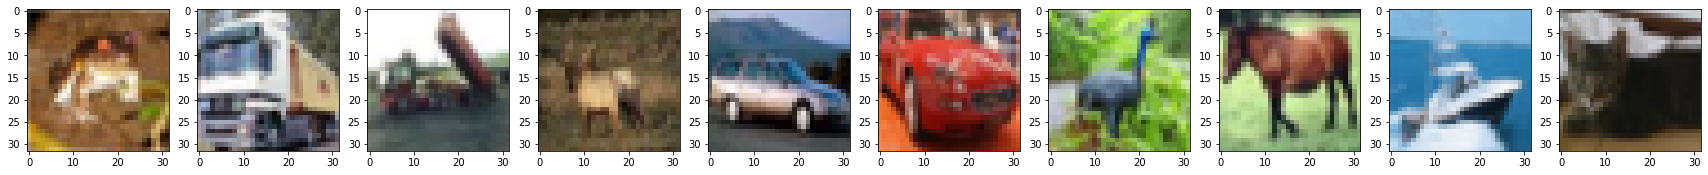

In [27]:
fig,axs = plt.subplots(1,10,figsize=(30,10))
for i in range(10):
    axs[i].imshow(RGB_X[i])
    print(RGB_Y[i])

In [22]:
np.max(RGB_X)

1.0

In [23]:
with open('cifar-10-batches-py/test_batch', 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    
dict_label = dict_[b'labels']
RGB_TEST_Y = np.asarray(dict_label)   
data_ = dict_[b'data']
data_ = np.asarray(data_)
data_r = data_[:,0:1024]
data_g = data_[:,1024:2048]
data_b = data_[:,2048:3072]
data_r = data_r.reshape(10000,32,32,1)
data_g = data_g.reshape(10000,32,32,1)
data_b = data_b.reshape(10000,32,32,1)
RGB_TEST_X = np.concatenate((data_r,data_g,data_b),axis=3)
RGB_TEST_X = RGB_TEST_X/255.0

In [63]:
new_test[0].shape

(10000, 32, 32, 3)

3
8
8
0
6
6
1
6
3
1


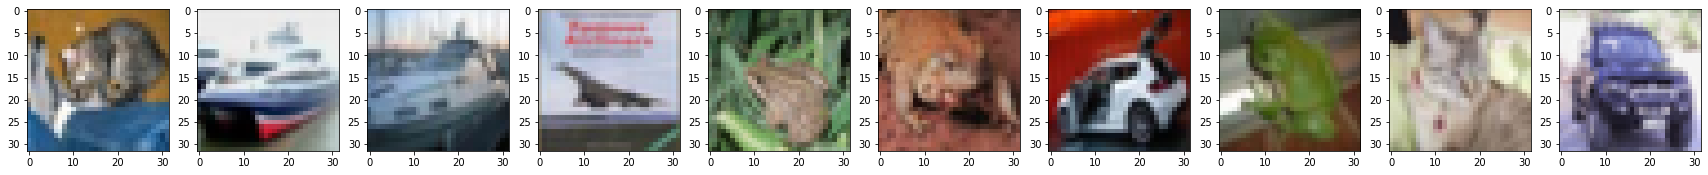

In [28]:
fig,axs = plt.subplots(1,10,figsize=(30,10))
for i in range(10):
    axs[i].imshow(RGB_TEST_X[i])
    print(RGB_TEST_Y[i])

In [83]:
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
#from cse_498 import progress_bar

In [64]:
trainloader = torch.utils.data.DataLoader(
    [RGB_X,RGB_Y], batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(
    [RGB_TEST_X,RGB_TEST_Y], batch_size=100, shuffle=False)

In [77]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [41]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true',
                     help='resume from checkpoint')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [43]:
args = parser.parse_args

In [44]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [47]:
net = ResNet18()
net = net.to(device)

In [48]:
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [84]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

#         progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                      % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

#             progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                          % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc




In [85]:
for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
Loss: 3.049 | Acc: 18.750% (24/128)
Loss: 3.628 | Acc: 16.016% (41/256)
Loss: 4.227 | Acc: 14.323% (55/384)
Loss: 4.767 | Acc: 15.625% (80/512)
Loss: 5.038 | Acc: 16.719% (107/640)
Loss: 5.086 | Acc: 16.536% (127/768)


KeyboardInterrupt: 